# Multivariate linear regression

In [1]:
from __future__ import division

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd # used in section 3.1
from scipy import linalg # used in section 3.3
from sklearn.linear_model import LinearRegression # used in the final section of the notebook
from utils import (plot_feature_corr, plot_clusters,
                   plot_pca, plot_feature_importance,
                   pr_curve, print_classfication_report,
                   read_data, write_data, score_model)
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

In [3]:
%matplotlib inline 

In [4]:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")

# 3 Linear regression with multiple variables

Load the dataset.

In [5]:
data = open('data/data_ex2.csv').readlines()
data = [x.strip().replace("$","").split(' ',0) for x in data]
data = np.array([list(map(float,x[0].replace(',', '').split())) for x in data])
data.shape

(95, 6)

In [11]:
y = data[:, 0]
data = data[:, 1:] 
data.shape
X1 = data[:,0] * data[:,1]
X2 = data[:,2] / data[:,3]
X3 = data[:,4]
X4 = X1 * X1
X5 = X2 * X2
X6 = X3 * X3
X7 = X1 * X2
X8 = X1 * X3
X9 = X2 * X3
X10 = X1 * X2 * X3
data = np.vstack((X1,X2,X3, X4, X5, X6, X7, X8, X9, X10)).T
X = data
M = len(y) 
data.shape

(95, 10)

Visualize 2D projections of the data.

/space/megryan/1/users/sheraz/python/anaconda3n/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


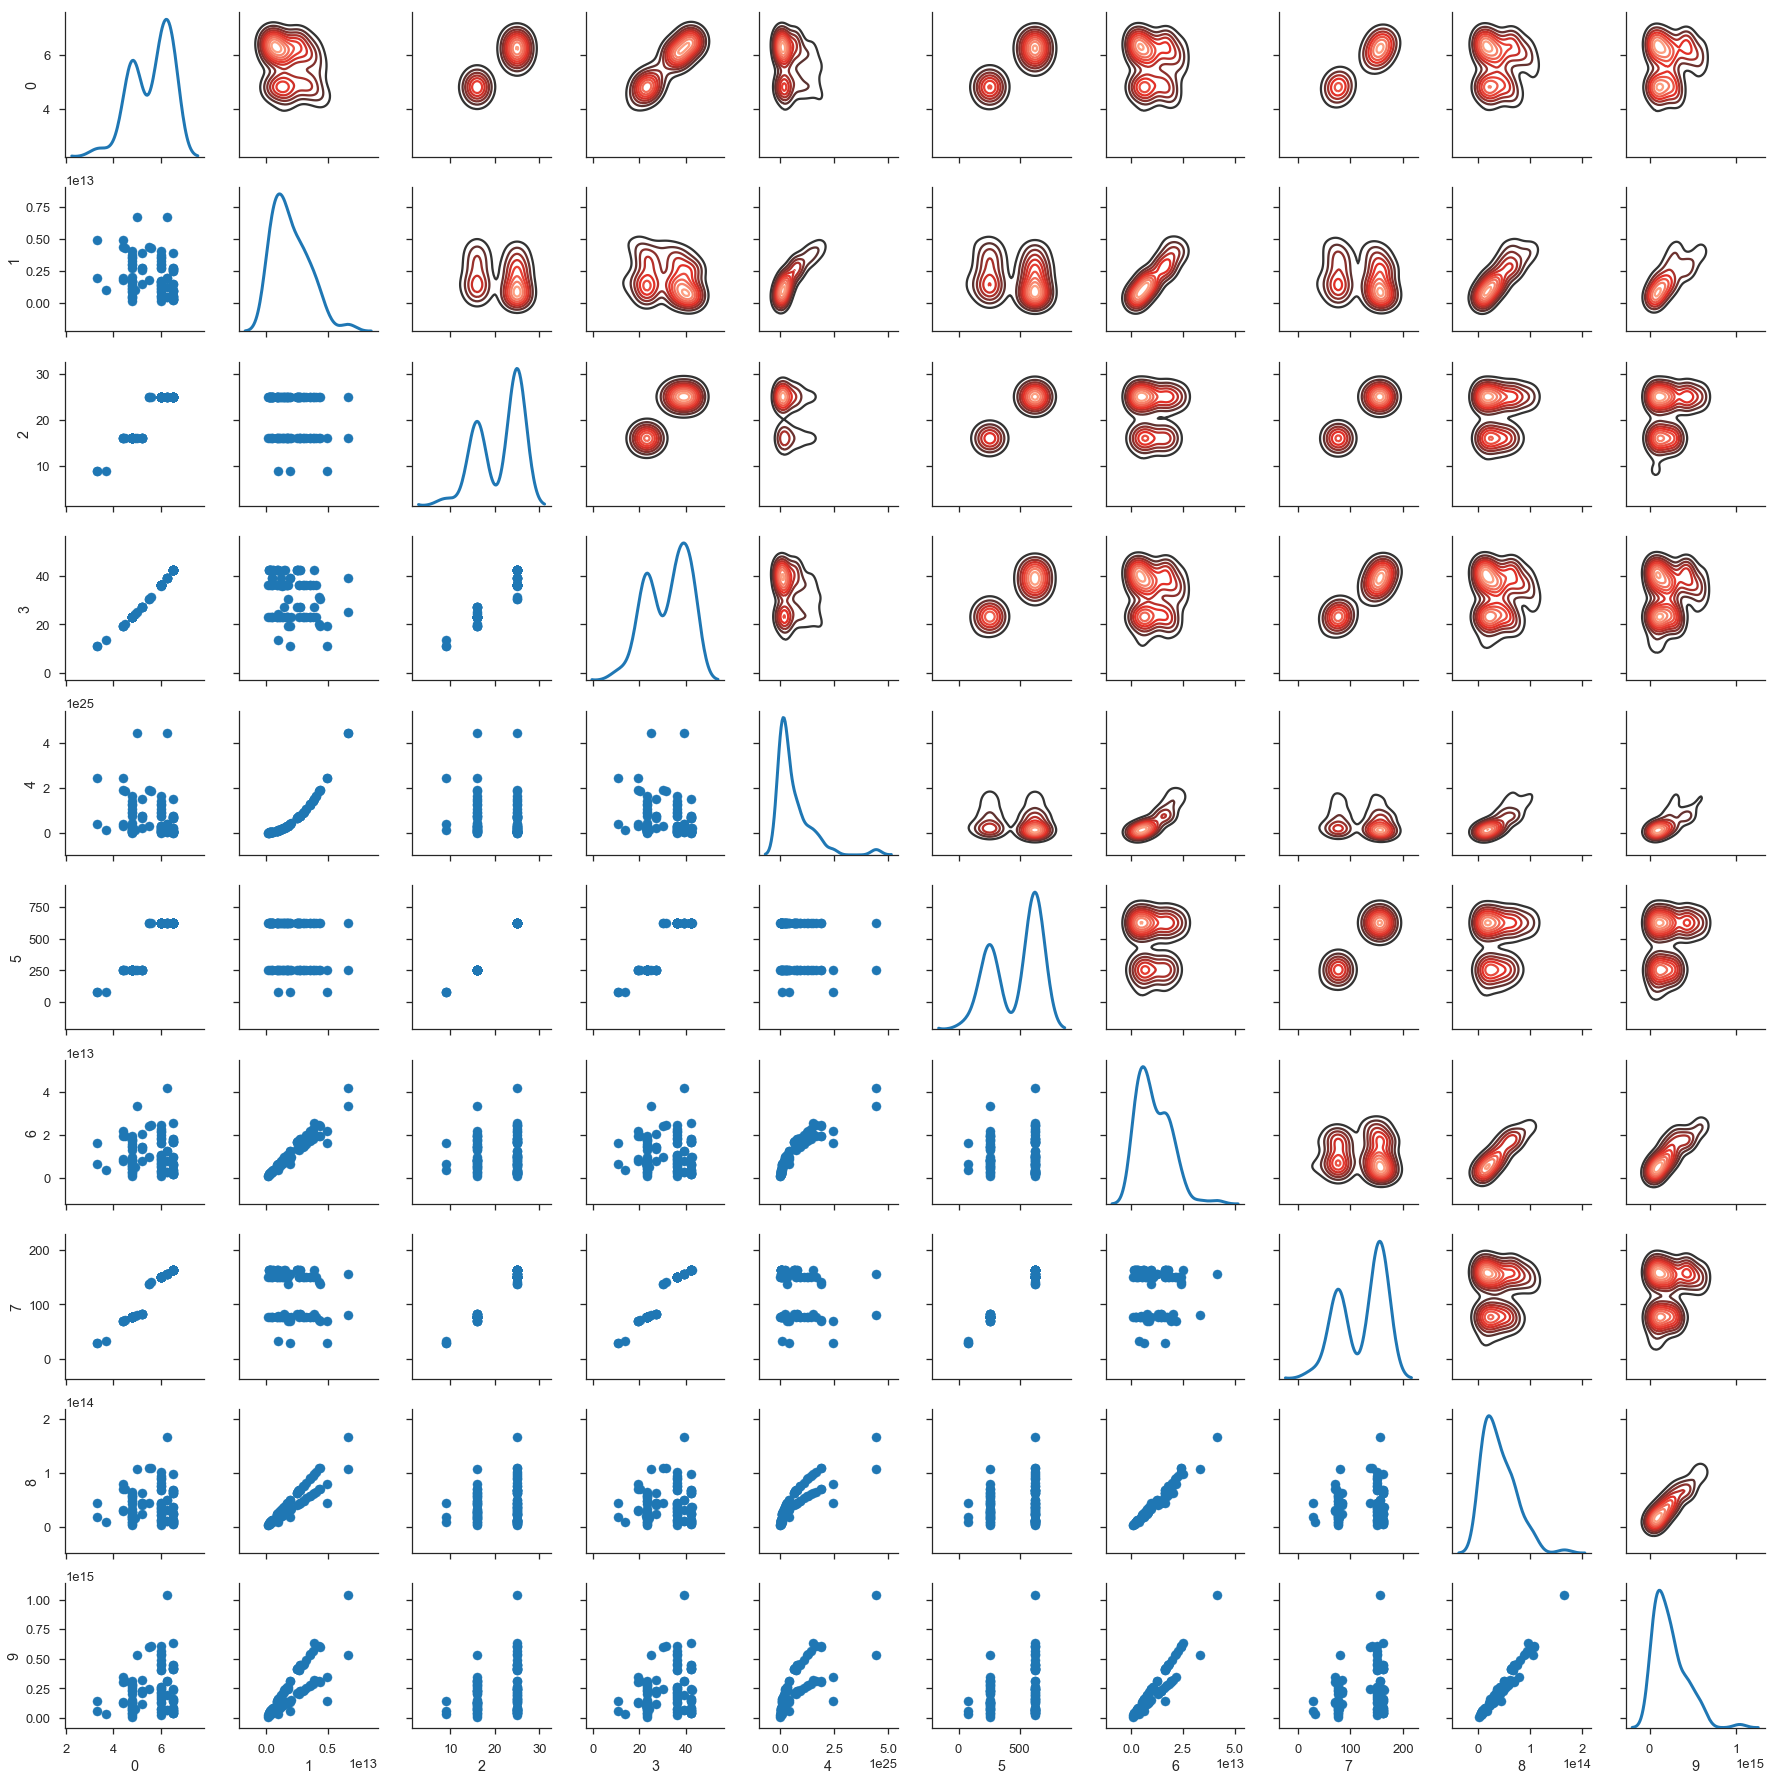

In [12]:
df = pd.DataFrame(data)

g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.kdeplot, cmap="Reds_d")
g.map_lower(plt.scatter)
g.map_diag(sns.kdeplot, lw=3);

## 3.1 Feature normalization

Add a column of ones to the data matrix that allows us to treat the intercept parameter as a feature.

Define a function returning the normalized data matrix as well as feature means and standard deviations.

In [13]:
def feature_normalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    
    X_norm_T = np.ones_like(X.T)
    for i, feature in enumerate(X.T):
        if i == 0: continue # skip normalization of the column of ones in X 
        X_norm_T[i] = (feature - mu[i]) / sigma[i]
        
    return X_norm_T.T, mu, sigma

Normalize the features.

In [14]:
X_norm, mu, sigma = feature_normalize(X)
X.shape[1]

10

## 3.2 Gradient descent

Initialize each of the three model parameters to zero. 

In [15]:
theta_0 = np.zeros(X.shape[1])

Define the cost function for multivariate regression.  (It ends up being the same function as for the univariate case due to vectorization.)

In [18]:
def compute_cost(X, y, M, theta):
    return 0.5 * np.mean((theta.dot(X.T) - y)**2)

Test it.

In [19]:
print(compute_cost(X_norm, y, M, theta_0))
X_norm.shape

1.49139259471e+12


(95, 10)

Define hyperparameters for batch gradient descent.

In [20]:
num_iters = 1000
alpha = 0.1

Implement the gradient descent algorithm. (Again, it ends up being the same function as for the univariate case.)

In [21]:
def gradient_descent(X, y, M, theta_0, alpha, num_iters):
    J_history = np.zeros(num_iters)
    theta = theta_0.copy()
    for i in range(num_iters):
        J_history[i] = compute_cost(X, y, M, theta)
        theta -= alpha / M * (theta.dot(X.T) - y).dot(X)
        
    return theta, J_history

Test it.

In [22]:
theta, J_history = gradient_descent(X_norm, y, M, theta_0, alpha, num_iters)

In [23]:
print('Theta found by gradient descent:', ', '.join('%.3f' % item for item in theta))

Theta found by gradient descent: 1613808.254, 589212.473, -115106.284, 149457.828, -344650.512, -56644.690, 446600.424, 10312.564, -26120.326, -81034.618


Plot cost vs. steps.

(0, 1565962224442.9668)

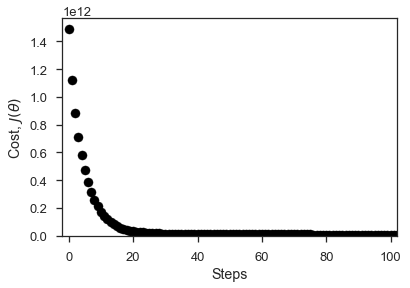

In [24]:
plt.figure()
plt.scatter(np.arange(num_iters), J_history, c='k', marker='o')
plt.xlabel('Steps')
plt.ylabel('Cost, ' + r'$J(\theta)$')
plt.xlim(-num_iters / 10 * 0.02, num_iters / 10 * 1.02)
plt.ylim(0, max(J_history) * 1.05)

Plot cost vs. steps for multiple choices of the learning rate, alpha.

In [25]:
_, J_history_1 = gradient_descent(X_norm, y, M, theta_0, 0.01, num_iters)
_, J_history_2 = gradient_descent(X_norm, y, M, theta_0, 0.03, num_iters)
_, J_history_3 = gradient_descent(X_norm, y, M, theta_0, 0.30, num_iters)

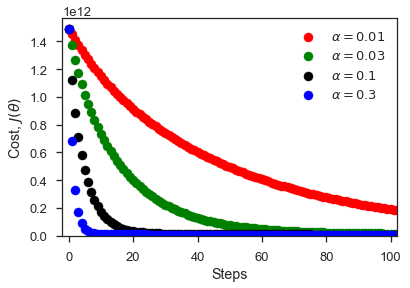

In [26]:
plt.figure()
plt.scatter(np.arange(num_iters), J_history_1, c='r', marker='o', label=r'$\alpha=0.01$')
plt.scatter(np.arange(num_iters), J_history_2, c='g', marker='o', label=r'$\alpha=0.03$')
plt.scatter(np.arange(num_iters), J_history, c='k', marker='o', label=r'$\alpha=0.1$')
plt.scatter(np.arange(num_iters), J_history_3, c='b', marker='o', label=r'$\alpha=0.3$')
plt.xlabel('Steps')
plt.ylabel('Cost, ' + r'$J(\theta)$')
plt.xlim(-num_iters / 10 * 0.02, num_iters / 10 * 1.02)
plt.ylim(0, max(J_history) * 1.05)
plt.legend(numpoints=1, loc=0)

Define a function that returns the model prediction for price.

In [27]:
def prediction(theta, x0, x1, mu, sigma):
    return theta[0] + (x0 - mu[1]) / sigma[1] * theta[1] + (x1 - mu[2]) / sigma[2] * theta[2]

Compare training data with linear regression predictions.

## 3.3 Normal equations

Define a function to compute the analytical solution to linear regression.

In [28]:
def normal_eqn(X, y):
    return linalg.inv(X.T.dot(X)).dot(X.T).dot(y).T

Test it.

In [29]:
theta_from_normal_eqn = normal_eqn(X_norm, y)

In [30]:
print('Best fit parameters obtained from gradient descent:' + '.'.join('%.3f' % item for item in theta))
print('Best fit parameters obtained from the normal equations:' + ','.join('%.3f' % item for item in theta_from_normal_eqn))
    
X.shape

Best fit parameters obtained from gradient descent:1613808.254.589212.473.-115106.284.149457.828.-344650.512.-56644.690.446600.424.10312.564.-26120.326.-81034.618
Best fit parameters obtained from the normal equations:1613808.254,560743.973,-16643.684,397368.813,-350692.339,577528.263,881591.833,-946625.396,-665784.259,149306.670


(95, 10)

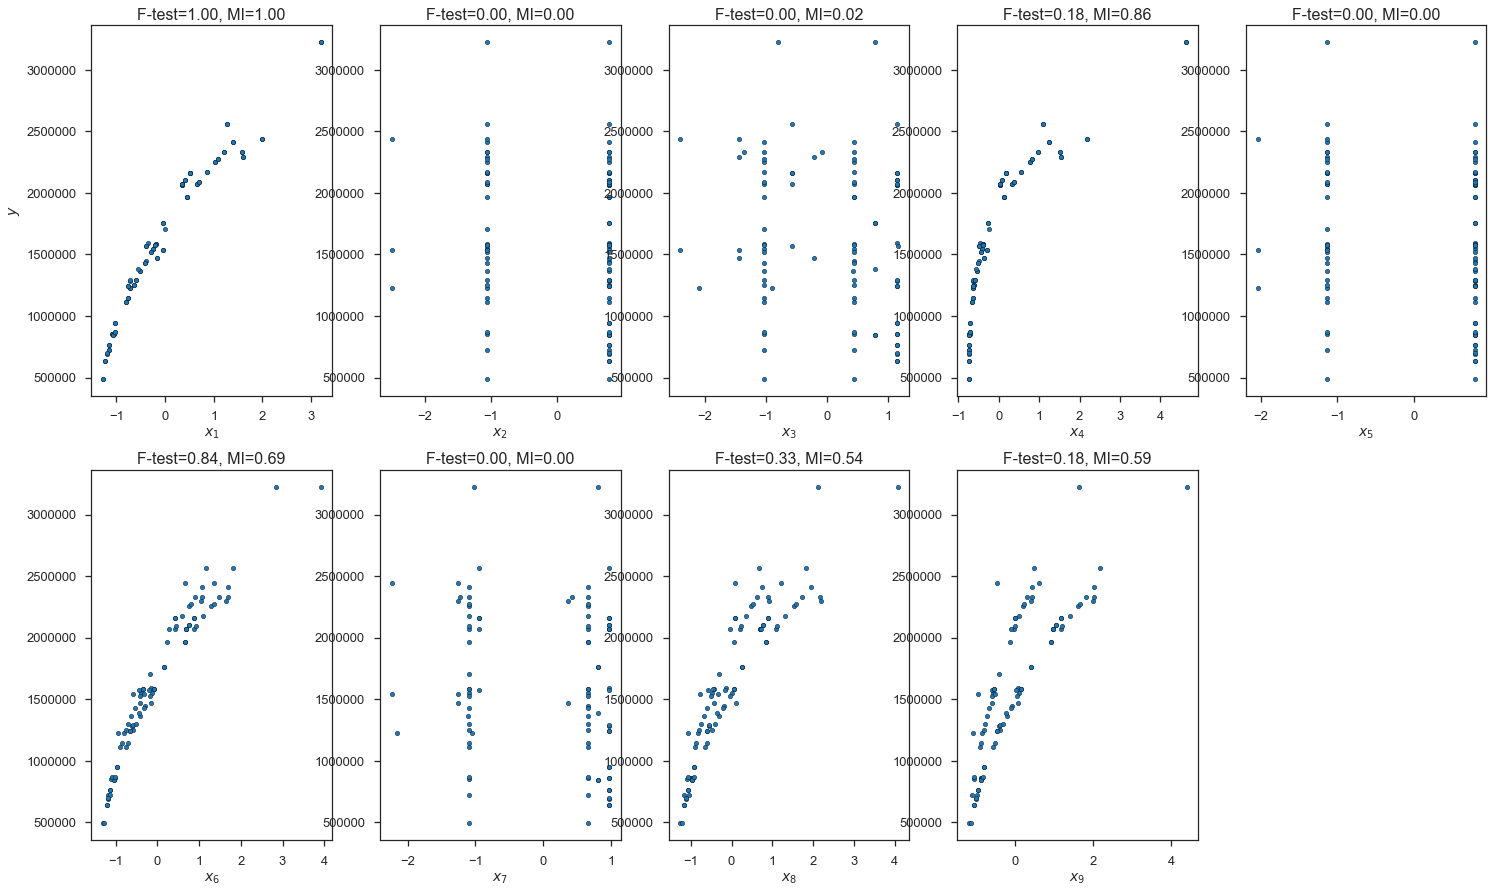

In [31]:
from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X_norm[:,1:], y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X_norm[:,1:], y)
mi /= np.max(mi)

plt.figure(figsize=(25, 15))
for i in range(X_norm.shape[1]-1):
    plt.subplot(2, X_norm.shape[1]/2, i + 1)
    plt.scatter(X_norm[:, i+1], y, edgecolor='black', s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
plt.show()

In [34]:
cost_history = []

def lin_reg_cost_function(theta, X, y, lam):

    cost = 1 / 2 / M * np.sum((theta.dot(X.T) - y)**2) + lam / 2 / M * np.sum(theta[1:]**2)
    
    cost_history.append(cost)
    return cost

In [38]:
lam = 1
lin_theta_0 = np.ones(X.shape[1])

cost = lin_reg_cost_function(lin_theta_0, X_norm, y, lam)

print(cost)

1.4913886648e+12


In [39]:
cost_history = []

def lin_reg_cost_function(theta, X, y, lam):
    """Python version of linearRegCostFunction.m after completing 'Part 3' of ex5.m."""
    
    cost = 1 / 2 / M * np.sum((theta.dot(X.T) - y)**2) + lam / 2 / M * np.sum(theta[1:]**2)
    
    grad = 1 / M * (theta.dot(X.T) - y).dot(X) + lam / M * np.array([0 if i == 0 else theta[i] for i in range(len(theta))])

    cost_history.append(cost)
    return cost, grad

In [75]:
lam = 0
lin_theta_0 = np.ones(X_norm.shape[1])

cost, grad = lin_reg_cost_function(lin_theta_0, X_norm, y, lam)

print(grad[0], grad[1])
print(cost)

-1613807.25408 -590805.060908
1.4913886648e+12


In [76]:
def train_linear_reg(lin_theta_0, X, y, lam):
    res = minimize(lin_reg_cost_function, lin_theta_0, method='L-BFGS-B', args=(X, y, lam), jac=True) 
    return res

def add_column_ones(x):
    if np.isscalar(x):
        x = np.array((1, x))
    else:
        x = np.vstack((np.ones((x.shape[0],)), x)).T
    return x

def prediction(theta, x, mu = 0, sigma = 1):
    theta = theta.reshape((len(theta), 1))
    x = (x - mu) / sigma
    x = add_column_ones(x)
    pred = np.dot(x, theta)
    return pred

      fun: 136758748946.20767
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.15582735, -0.31964444,  0.17792894, -0.15409549,  0.30646551,
        0.17224782, -0.20236935,  0.04284329,  0.07017818,  0.13236289])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 10
   status: 0
  success: True
        x: array([ 1613808.09825686,    39475.54399283,    -7162.4190109 ,
          -8009.97826747,    33290.11074436,    -7320.989947  ,
          39229.92749299,    -7779.82586   ,    36732.26312956,
          34091.73134175])


Text(0,0.5,'Cost')

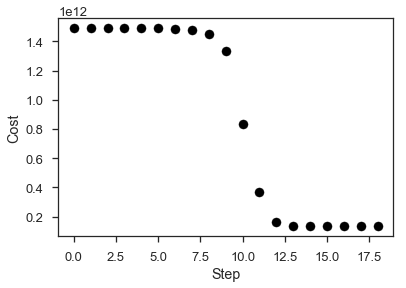

In [77]:
cost_history = []
lam = 1000
lin_theta_0 = np.ones(X_norm.shape[1])

res = train_linear_reg(lin_theta_0, X_norm, y, lam)

theta = res['x']
print(res)

num_steps = len(cost_history)

plt.figure()
plt.scatter(np.arange(num_steps), cost_history, c='k', marker='o')
plt.xlabel('Step')
plt.ylabel('Cost')

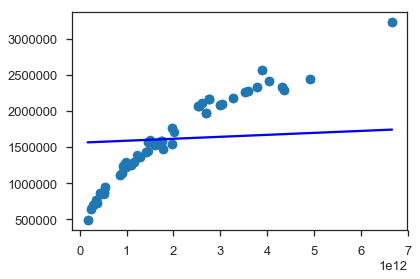

In [71]:
plt.figure()
plt.scatter(X[:,1], y)
x_pts = np.linspace(X[:,1].min(), X[:,1].max(), 100)
plt.plot(x_pts, prediction(theta[:2], x_pts, mu[1], sigma[1]), 'b-', label='Linear regression')
print()


In [74]:
X = np.vstack((np.ones(M), data.T)).T
M = len(X)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=42)


In [ ]:
def learning_curve(lin_theta_0, X, y, X_val, y_val, lam):
    error_train, error_val = np.zeros(M-1), np.zeros(M-1)
    for i in range(2, M+1):
        res_train = train_linear_reg(lin_theta_0, X[:i, :], y[:i], lam)
        theta = res_train['x']
        error_train[i-2], error_val[i-2] = \
            lin_reg_cost_function(theta, X[:i, :], y[:i], 0)[0], lin_reg_cost_function(theta, X_val, y_val, 0)[0]
    return error_train, error_val

In [ ]:
X_poly, mu, sigma = feature_normalize(X_train)
X_poly_val = val_or_test_feature_normalize(X_val, mu, sigma)
X_poly_test = val_or_test_feature_normalize(X_test, mu, sigma)


lin_reg_cost_function(lin_theta_0, X_poly[:i, :], y_train[:i], 0)

In [ ]:
print(X_poly.shape, y_train.shape, X_poly_val.shape, y_val.shape)
error_train, error_val = learning_curve(lin_theta_0, X_poly, y_train, X_poly_val, y_val, 0)

plt.figure()
plt.plot(np.arange(2, M+1), error_train, 'b-', label='Train')


In [ ]:
lam = 0
lin_theta_0 = np.ones(X_poly.shape[1])
res = train_linear_reg(lin_theta_0, X_poly, y_train, lam)

print(res)
theta = res['x']
plt.figure()
plt.plot(cost_history, 'ko', ms=8)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.yscale('log')